Dependencies

In [ ]:
!pip3 install keras tensorflow-gpu cudatoolkit cudnn
!pip3 install matplotlib
!pip3 install numpy
!pip3 install pandas
!pip3 install scikit-learn
!pip3 install seaborn
!pip3 install 'tensorflow[and-cuda]'

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/packaging/_parser.py", line 124, in _parse_requir

Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch
import os
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, Xception

2025-01-12 20:02:59.500282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736704979.514092     728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736704979.518706     728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 20:02:59.534552: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Init GPU

In [3]:
def setup_gpu():

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Number of TensorFlow GPUs: {len(gpus)}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return device
device = setup_gpu()

Number of TensorFlow GPUs: 1


Data preprocessing

In [4]:
def create_data_generators(data_dir='chest_xray', img_size=(256, 256), batch_size=32):

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        f'{data_dir}/train',
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary'
    )
    
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        f'{data_dir}/val',
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary'
    )
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        f'{data_dir}/test',
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary'
    )
    
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomContrast(0.2)
    ])
    
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    
    # Apply augmentation and normalization to training data
    train_dataset = train_dataset.map(
        lambda x, y: (data_augmentation(x), y)
    ).map(
        lambda x, y: (normalization_layer(x), y)
    )
    
    # Apply only normalization to validation and test data
    val_dataset = val_dataset.map(
        lambda x, y: (normalization_layer(x), y)
    )
    test_dataset = test_dataset.map(
        lambda x, y: (normalization_layer(x), y)
    )
    
    # Configure datasets for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_dataset, val_dataset, test_dataset


Data vizualization

In [5]:
directory = "chest_xray/train"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

/tmp/ipykernel_728/3026648010.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


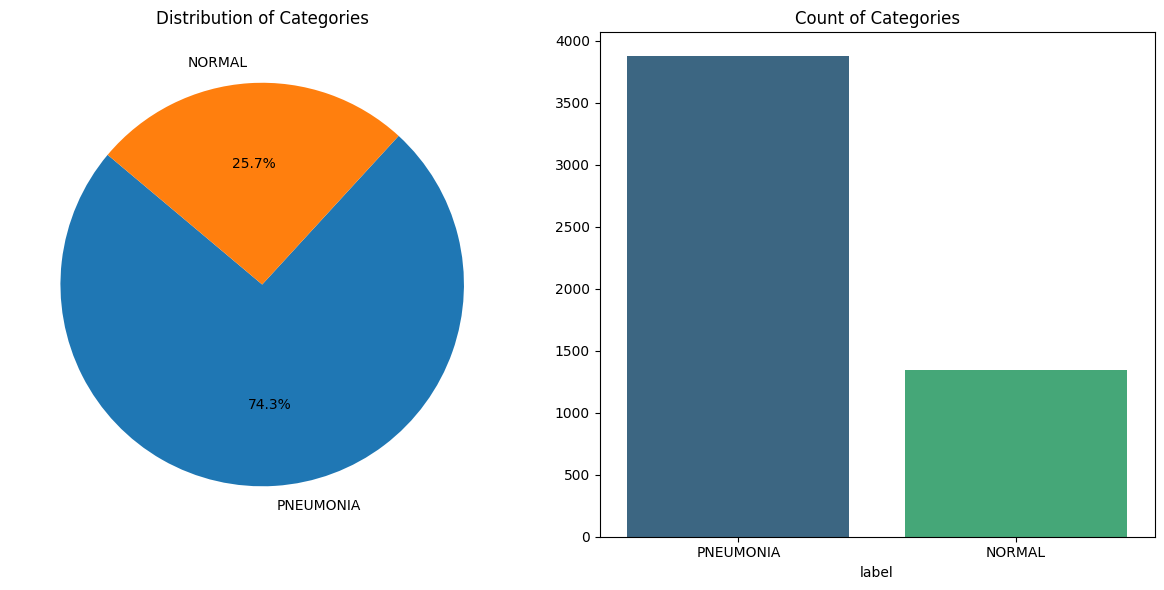

In [6]:
count = df_train['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

plt.tight_layout()

plt.show()

In [7]:
directory = "chest_xray/test"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

/tmp/ipykernel_728/2818601119.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


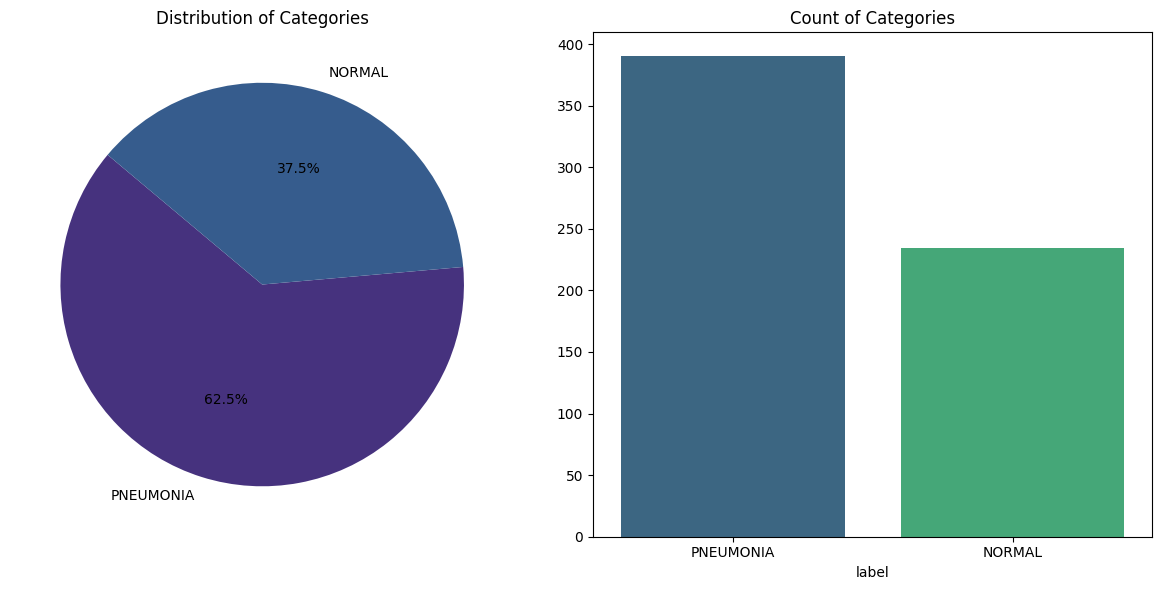

In [8]:
count = df_test['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

plt.tight_layout()

plt.show()

In [9]:
def visualize_images(path, num_images=5):
    
    image_filenames = os.listdir(path)
    
    num_images = min(num_images, len(image_filenames))
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)
    
    plt.tight_layout()
    plt.show()

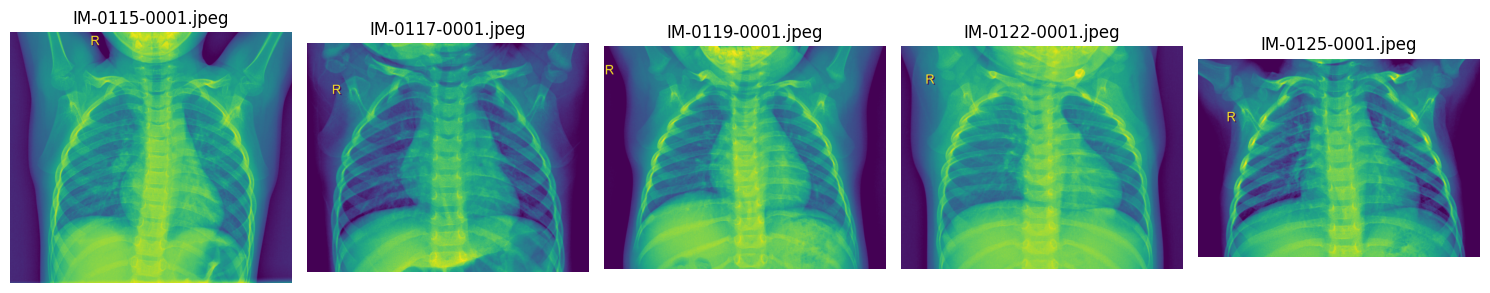

In [10]:
path_to_visualize = "chest_xray/train/NORMAL"
visualize_images(path_to_visualize, num_images=5)

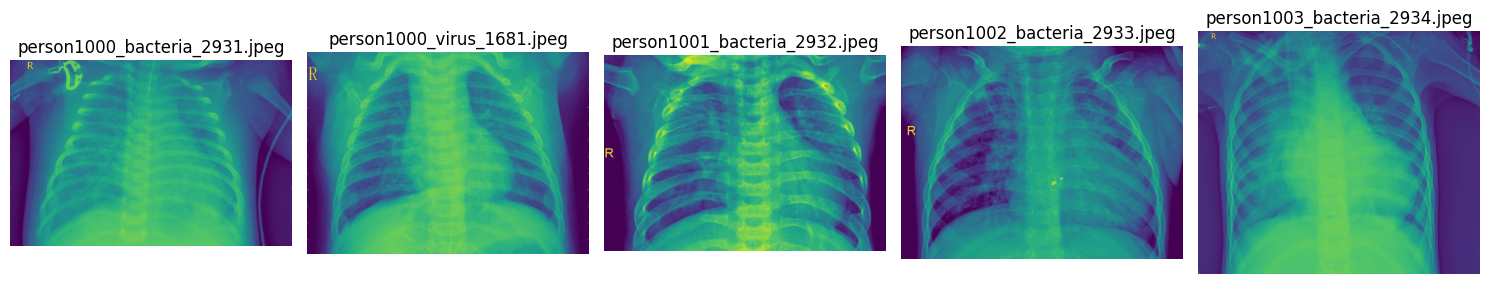

In [11]:
path_to_visualize = "chest_xray/train/PNEUMONIA"
visualize_images(path_to_visualize, num_images=5)

Model Architectures

In [13]:
def create_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.45),
        tf.keras.layers.Dense(220, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(60,activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    return model

In [12]:
def create_custom_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_transfer_learning_model(base_model_name='VGG16'):

    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
        for layer in base_model.layers[-20:]:
            layer.trainable = True
    elif base_model_name == 'CNN':
        base_model = create_custom_cnn()
        return base_model
    elif base_model_name == 'Xception':
        base_model = create_xception_model()
        return base_model
    if base_model_name == 'VGG16' or base_model_name == 'ResNet50' or base_model_name == 'CNN':
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    elif base_model_name == 'DenseNet121':
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    return model


Training

In [14]:
def load_saved_model(model_name):
    """Load a saved model"""
    try:
        return tf.keras.models.load_model(f'best_{model_name}.keras')
    except (OSError, IOError) as e:
        print("Model file not found, continuining with training...")
    return None

def evaluate_model(model, test_dataset):
    """Evaluate a model on test data"""
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    
    return test_loss, test_accuracy

In [15]:
def predict_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # For binary classification
    result = "Pneumonia" if prediction[0] > 0.5 else "Normal"
    confidence = prediction[0] if prediction[0] > 0.5 else 1 - prediction[0]
    
    return result, confidence

In [16]:
def train_and_evaluate(model, model_name, continue_training=False):

    model_path = f'best_{model_name}.h5'

    if not continue_training and os.path.exists(model_path):
        print(f"Loading existing model: {model_path}")
        model = tf.keras.models.load_model(model_path)
    else:
        print("Creating new model...")
        model = create_transfer_learning_model(model_name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]
    )


    callbacks = [
        tf.keras.callbacks.EarlyStopping(
        patience=5,  # Increased patience
        restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.00001
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'best_{model_name}.keras',
            save_best_only=True,
            monitor='val_f1_score'
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=callbacks
    )
    print(history)
    return history

Model Comparison

In [17]:
def plot_results(results):
    best_epoch = results['val_accuracy'].index(max(results['val_accuracy'])) + 1

    plt.style.use('seaborn-v0_8-darkgrid')

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Plot training and validation accuracy
    axs[0].plot(results['accuracy'], label='Training Accuracy', color='blue')
    axs[0].plot(results['val_accuracy'], label='Validation Accuracy', color='red')
    axs[0].scatter(best_epoch - 1, results['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].legend()

    # Plot training and validation loss
    axs[1].plot(results['loss'], label='Training Loss', color='blue')
    axs[1].plot(results['val_loss'], label='Validation Loss', color='red')
    axs[1].scatter(best_epoch - 1, results['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


In [18]:
test_dir = 'chest_xray/test/'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=(256, 256),
    batch_size=32)
class_labels = ['NORMAL', 'PNEUMONIA'] 
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):

    predictions = model.predict(dataset)
    
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()
        
        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if the total number of images exceeds the desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

Found 624 files belonging to 2 classes.


I0000 00:00:1736704984.647052     728 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [24]:
from tensorflow.keras import mixed_precision

def compare_models():
    models = {
        #'CNN': create_custom_cnn(),
        #'VGG16': create_transfer_learning_model('VGG16'),
        #'ResNet50': create_transfer_learning_model('ResNet50'),
        #'DenseNet121': create_transfer_learning_model('DenseNet121'),
        'Xception': create_xception_model()
    }
    
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        
        if name == "DenseNet121":
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)

        history = train_and_evaluate(model, name)

        if history.history != None:
            results = history.history
            plot_results(results)
            results = None
        
        tf.keras.backend.clear_session()
        with torch.no_grad():
            torch.cuda.empty_cache()
    



Comparison

In [20]:
def plot_performance_comparison(metrics):
    # Bar plot for Recall and F1 Score
    plt.figure(figsize=(12, 6))
    
    models = list(metrics.keys())
    recalls = [m['recall'] for m in metrics.values()]
    f1_scores = [m['f1'] for m in metrics.values()]
    
    x = np.arange(len(models))
    width = 0.35
    
    plt.bar(x - width/2, recalls, width, label='Recall')
    plt.bar(x + width/2, f1_scores, width, label='F1 Score')
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
def plot_confusion_matrices(metrics):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Confusion Matrices for Different Models')
    
    for (name, metric), ax in zip(metrics.items(), axes.flat):
        sns.heatmap(metric['confusion_matrix'], 
                   annot=True, 
                   fmt='d',
                   cmap='Blues',
                   ax=ax)
        ax.set_title(name)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()

def create_performance_table(metrics):
    data = {
        'Model': [],
        'Recall': [],
        'F1 Score': []
    }
    
    for name, metric in metrics.items():
        data['Model'].append(name)
        data['Recall'].append(f"{metric['recall']:.4f}")
        data['F1 Score'].append(f"{metric['f1']:.4f}")
    
    return pd.DataFrame(data)

In [22]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score

def load_and_evaluate_models(test_ds):
    metrics = {}
    
    model_names = ['ResNet50', 'VGG16', 'DenseNet121', 'CNN']
    
    for name in model_names:
        model = load_saved_model(name)
        
        y_pred = model.predict(test_ds)
        y_pred = (y_pred > 0.5).astype(int)
        
        y_true = np.concatenate([y for x, y in test_ds], axis=0)
        
        metrics[name] = {
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }

        plot_images_with_predictions(model, test_ds, class_labels, num_images=20, num_images_per_row=5)

    return metrics

Main Program

Running code on GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN...
Creating new model...
Epoch 1/20


I0000 00:00:1736705005.287975     907 service.cc:148] XLA service 0x7f3f74003090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736705005.288021     907 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-01-12 20:03:25.335891: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736705005.497676     907 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/163 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7927 - f1_score: 0.9018 - loss: 0.7334 - recall: 0.9656

I0000 00:00:1736705011.295166     907 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.7470 - f1_score: 0.8573 - loss: 0.5997 - recall: 0.9947 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - val_loss: 0.8275 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7830 - f1_score: 0.8573 - loss: 0.4290 - recall: 0.9772 - val_accuracy: 0.6250 - val_f1_score: 0.6667 - val_loss: 0.9388 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8207 - f1_score: 0.8573 - loss: 0.3494 - recall: 0.9556 - val_accuracy: 0.6250 - val_f1_score: 0.6667 - val_loss: 0.7294 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8509 - f1_score: 0.8573 - loss: 0.3132 - recall: 0.9431 - val_accuracy: 0.6875 - val_f1_score: 0.6667 - val_loss: 0.6247 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accura

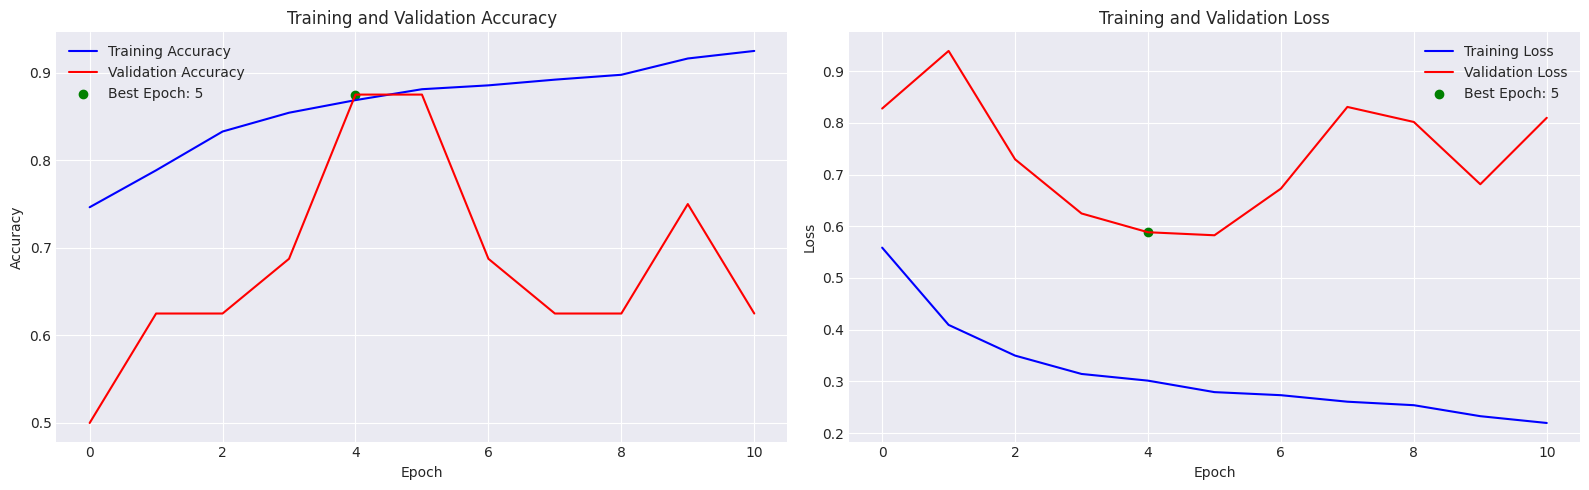

Training VGG16...
Creating new model...
Epoch 1/20


2025-01-12 20:05:04.964461: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1904', 60 bytes spill stores, 64 bytes spill loads

2025-01-12 20:05:05.016870: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1904', 68 bytes spill stores, 72 bytes spill loads

2025-01-12 20:05:05.374149: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1904', 24 bytes spill stores, 24 bytes spill loads

2025-01-12 20:05:06.778196: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more mem

163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 299ms/step - accuracy: 0.7899 - f1_score: 0.8573 - loss: 0.4178 - recall: 0.8893 - val_accuracy: 0.5625 - val_f1_score: 0.6667 - val_loss: 2.0497 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.8618 - f1_score: 0.8573 - loss: 0.3057 - recall: 0.9019 - val_accuracy: 0.5625 - val_f1_score: 0.6667 - val_loss: 1.6401 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.8875 - f1_score: 0.8573 - loss: 0.2609 - recall: 0.9099 - val_accuracy: 0.6875 - val_f1_score: 0.6667 - val_loss: 0.5105 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.9160 - f1_score: 0.8573 - loss: 0.2053 - recall: 0.9379 - val_accuracy: 0.8125 - val_f1_score: 0.6667 - val_loss: 0.3406 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step 

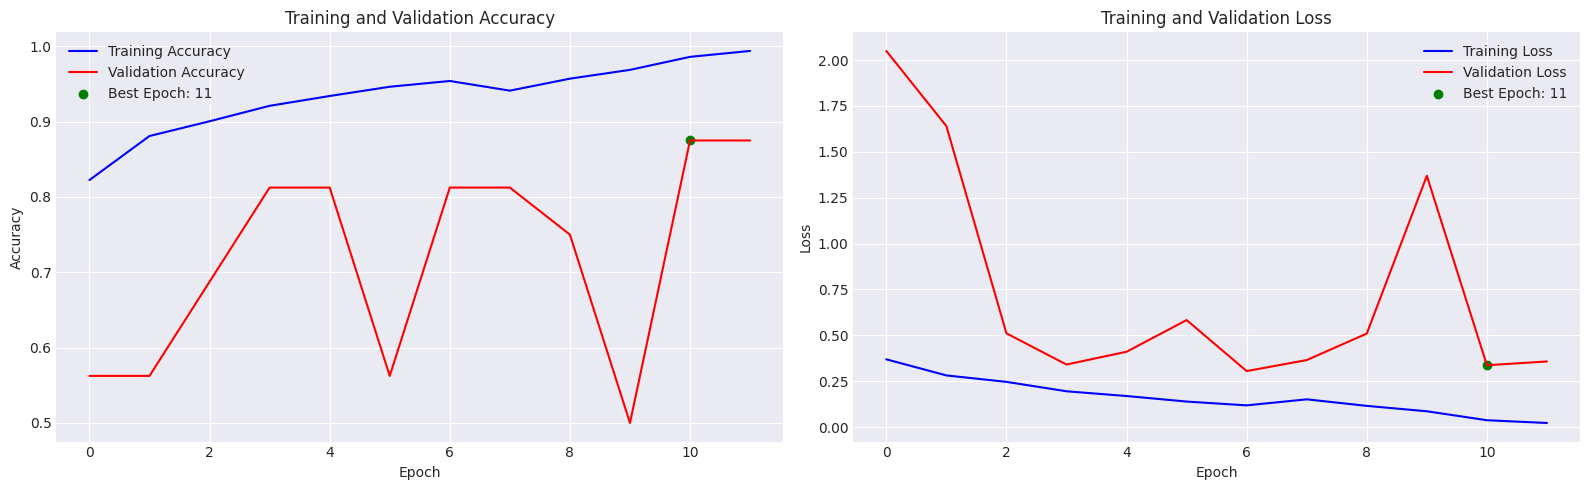

Training ResNet50...
Creating new model...
Epoch 1/20


2025-01-12 20:14:24.434492: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16371_0', 112 bytes spill stores, 224 bytes spill loads

2025-01-12 20:14:24.631543: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16371', 220 bytes spill stores, 576 bytes spill loads

2025-01-12 20:14:24.915976: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20857', 24 bytes spill stores, 24 bytes spill loads

2025-01-12 20:14:24.952291: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20857', 60 bytes spill stores, 64 bytes spill loads

2025-01-12 20:14:24.973152: I external/local_xla/x

163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 205ms/step - accuracy: 0.8870 - f1_score: 0.8573 - loss: 0.2362 - recall: 0.9207 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - val_loss: 3.6915 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9782 - f1_score: 0.8574 - loss: 0.0556 - recall: 0.9847 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - val_loss: 2.8318 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9934 - f1_score: 0.8583 - loss: 0.0192 - recall: 0.9955 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - val_loss: 11.5045 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.9889 - f1_score: 0.8596 - loss: 0.0297 - recall: 0.9916 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - val_loss: 4.5562 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step

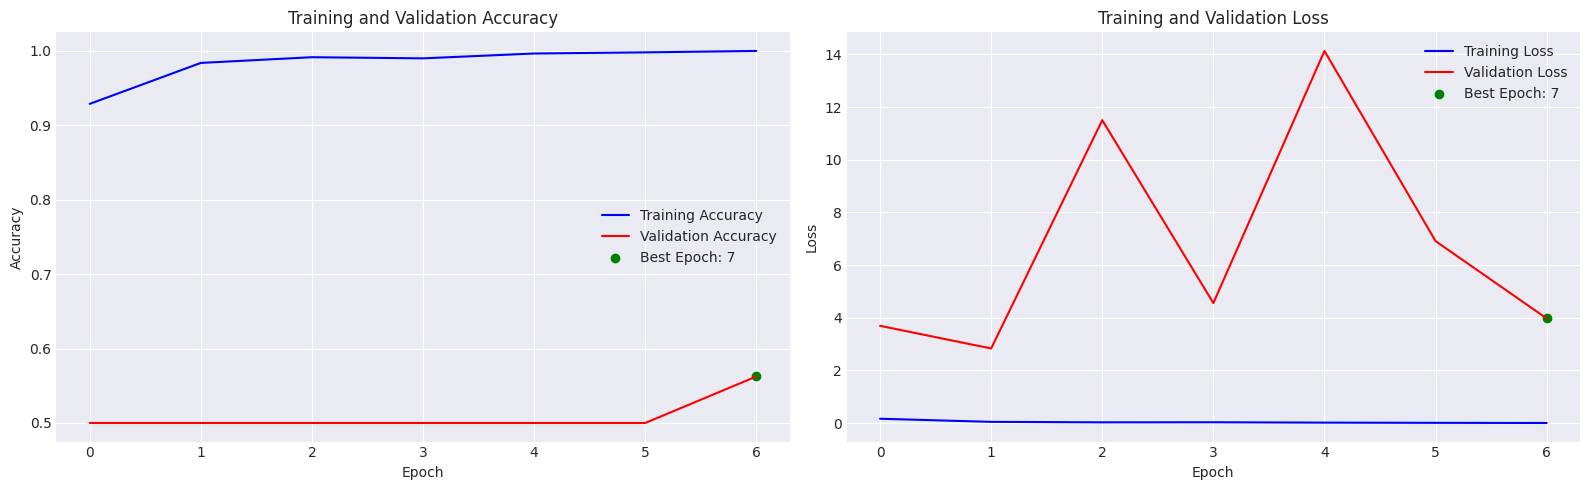

Training DenseNet121...
Creating new model...
Epoch 1/20


2025-01-12 20:19:03.926342: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[64,7,7,4]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,256,256,4]{3,2,1,0}, f16[32,128,128,64]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-12 20:19:04.240227: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.313982623s
Trying algorithm eng0{} for conv (f16[64,7,7,4]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,256,256,4]{3,2,1,0}, f16[32,128,128,64]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_bac

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7575 - f1_score: 0.8649 - loss: 0.5974 - recall: 0.7375

2025-01-12 20:20:39.585688: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3707', 12 bytes spill stores, 12 bytes spill loads

2025-01-12 20:20:39.740434: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3707', 12 bytes spill stores, 12 bytes spill loads

2025-01-12 20:20:39.768833: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3720', 12 bytes spill stores, 12 bytes spill loads



163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 275ms/step - accuracy: 0.7580 - f1_score: 0.8649 - loss: 0.5963 - recall: 0.7381 - val_accuracy: 0.7500 - val_f1_score: 0.6667 - val_loss: 0.4752 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 174ms/step - accuracy: 0.9418 - f1_score: 0.9044 - loss: 0.1983 - recall: 0.9527 - val_accuracy: 0.7500 - val_f1_score: 0.6667 - val_loss: 0.3512 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.9835 - f1_score: 0.9274 - loss: 0.0699 - recall: 0.9877 - val_accuracy: 0.6875 - val_f1_score: 0.6667 - val_loss: 0.9620 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.9921 - f1_score: 0.9344 - loss: 0.0358 - recall: 0.9935 - val_accuracy: 0.7500 - val_f1_score: 0.6957 - val_loss: 0.8404 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 173ms/step

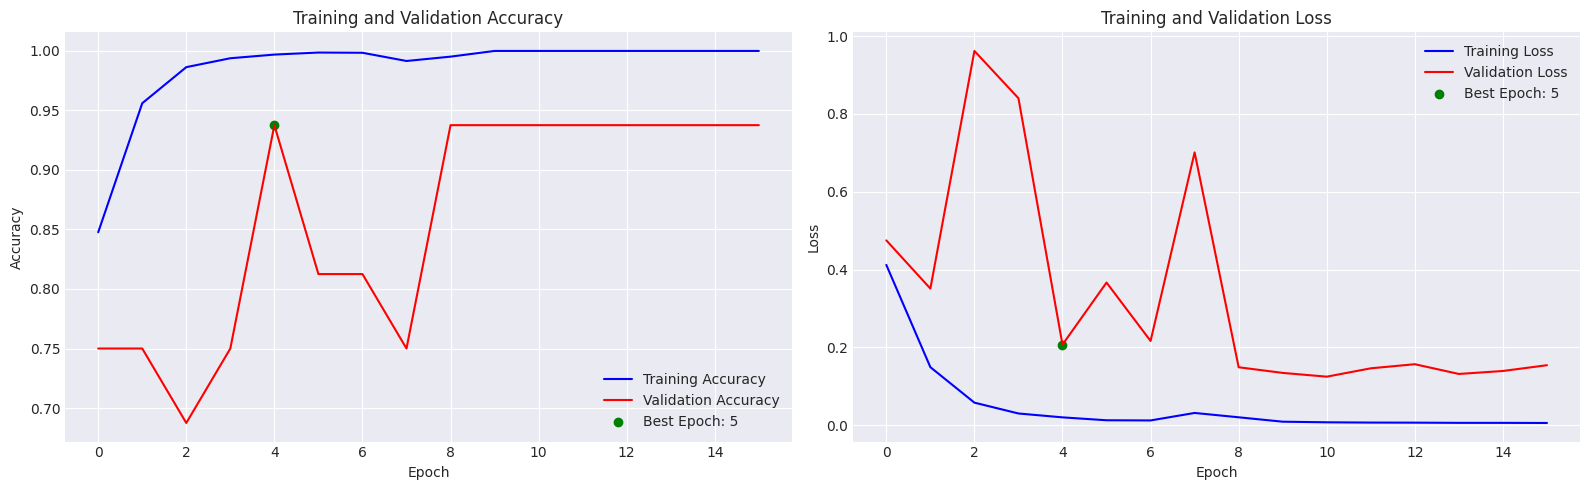

Training Xception...
Creating new model...


UnboundLocalError: local variable 'model' referenced before assignment

In [23]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running code on GPU:", gpus)
else:
    print("Running code on CPU:", tf.config.list_physical_devices('CPU'))

train_ds, val_ds, test_ds = create_data_generators()

compare_models()
metrics = load_and_evaluate_models(test_ds)

plot_performance_comparison(metrics)
plot_confusion_matrices(metrics)

performance_table = create_performance_table(metrics)
print("\nModel Performance Metrics:")
print(performance_table)


